**Import Necessary Libraries**

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**Load Dataset**

In [2]:
# Define EMO-DB emotion mapping
emotion_map = {
    'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear',
    'F': 'happiness', 'T': 'sadness', 'N': 'neutral'
}

# Path to the dataset folder
DATASET_PATH = "/content/drive/MyDrive/wav"

# Collect file names and labels
data = []
for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        emotion_code = file[5]  # 6th character in filename
        if emotion_code in emotion_map:
            emotion_label = emotion_map[emotion_code]
            data.append((os.path.join(DATASET_PATH, file), emotion_label))

# Create DataFrame
df = pd.DataFrame(data, columns=["filepath", "emotion"])
print(df.head())

                                 filepath    emotion
0  /content/drive/MyDrive/wav/03a02Ta.wav    sadness
1  /content/drive/MyDrive/wav/03a02Fc.wav  happiness
2  /content/drive/MyDrive/wav/03a01Wa.wav      anger
3  /content/drive/MyDrive/wav/03a02Nc.wav    neutral
4  /content/drive/MyDrive/wav/03a01Fa.wav  happiness


In [3]:
# Count files for each emotion
emotion_counts = df['emotion'].value_counts()
print("\nNumber of files per emotion:")
print(emotion_counts)


Number of files per emotion:
emotion
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
Name: count, dtype: int64


**Preprocessing of Data**

In [4]:
def extract_features(file_path, max_pad_len=200):
    """Extract MFCC features from an audio file."""
    audio, sample_rate = librosa.load(file_path, sr=16000)  # Load with 16kHz
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract 40 MFCCs
    pad_width = max_pad_len - mfccs.shape[1]

    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]

    return mfccs

# Extract features for all audio files
df["features"] = df["filepath"].apply(lambda x: extract_features(x))

In [5]:
# Convert features to numpy array
X = np.array(df["features"].tolist())

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(df["emotion"])
y = to_categorical(y)  # One-hot encoding

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build the CNN-LSTM Model**

In [6]:
# Reshape input for CNN
X_train = X_train.reshape(X_train.shape[0], 40, 200, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 200, 1)

# Build model
model = Sequential([
    # CNN Layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 200, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    TimeDistributed(Flatten()),  # Convert CNN output for LSTM
    LSTM(64, return_sequences=True),
    LSTM(64),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # Output layer
])

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 198, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 48, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 3072)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8, 64)               │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 859,527 (3.28 MB)

 Trainable params: 859,527 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.1884 - loss: 1.9497 - val_accuracy: 0.2243 - val_loss: 1.8549
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.2508 - loss: 1.8638 - val_accuracy: 0.2991 - val_loss: 1.8019
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.2704 - loss: 1.8063 - val_accuracy: 0.3364 - val_loss: 1.7629
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.3553 - loss: 1.7028 - val_accuracy: 0.4206 - val_loss: 1.6157
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.3757 - loss: 1.5451 - val_accuracy: 0.4393 - val_loss: 1.5274
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.4435 - loss: 1.4603 - val_accuracy: 0.4486 - val_loss: 1.4144
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.5227 - loss: 1.3633 - val_accuracy: 0.5234 - val_loss: 1.3222
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.4583 - loss: 1.3137 - val_accuracy: 

**Evaluate the Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.4817 - loss: 1.3092
Test Accuracy: 0.47


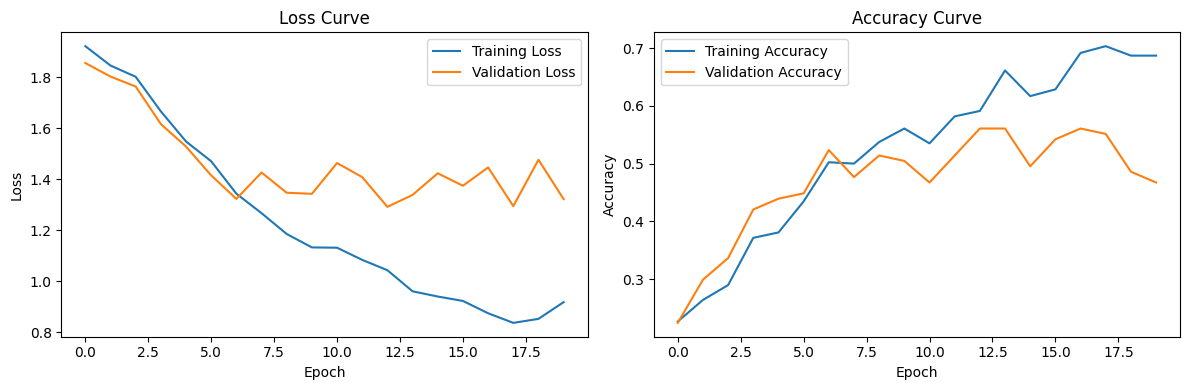

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step


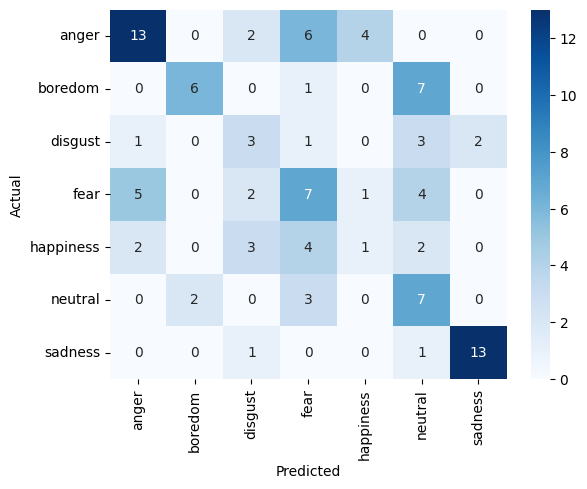

In [8]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


# Predict and display confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
